In [37]:
import sys
import os

# Construct the full path to the directory containing the package
project_path = '/workspace/apolune'

# Add the directory to sys.path
sys.path.append(project_path)

import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import dynamics.crtbp_dynamics as crtbp
import dynamics_coeff.dynamics_general as dyn_coeff
import propagation.propagator as propagation
import spiceypy as spice
import init.load_kernels as krn
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
import dynamics.rnbp_rpf_utils as utils
import dynamics.rnbp_rpf_dynamics_nonuniform as dyn_rnbp_nonuniform
from utils.API import api_get

In [40]:
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

# Attractors and their gravitational parameters
# spice.furnsh("kernels/pck/pck00010.tpc")  

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 

observer_id = 0

id_primary = id_ear[0]
id_secondary = id_moo[0]

id_bodies = [id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]]
naif_id_bodies = [id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]]
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

MU = mu_bodies[id_primary] + mu_bodies[id_secondary]
# https://www.jpl.nasa.gov/_edu/pdfs/scaless_reference.pdf
# https://www.jpl.nasa.gov/_edu/pdfs/ssbeads_answerkey.pdf
if id_primary == id_ear[0] and id_secondary == id_moo[0]:
    LU = 384400 # [km]
elif id_primary == id_sun[0] and id_secondary == id_ear[0]:
    LU = 1*AU 
elif id_primary == id_sun[0] and id_secondary == id_jup[0]:
    LU = 5.2*AU
else:
    raise ValueError("Invalid primary and secondary body combination")

TU = np.sqrt(LU**3 / MU) # scaling factor for time [s]
VU = LU / TU # [km/s]
om0 = 1/TU # constant [1/s] 

et0 = spice.str2et('1 Jan 2017 00:00:00 TDB');

# mu_crtbp = 1.21506683e-2
# mu_sun = 3.28900541e5
#mu_crtbp = mu_bodies[id_secondary] / MU
mu_sun = mu_bodies[id_sun[0]] / MU

sun_angle_t0 = 0.671
om_sun = -9.25195985e-1
a_sun = 3.88811143e2;

#LU = 3.84405000e5 # km
#TU = 4.34811305*86400 # seconds
#VU = 1.02323281 # km/s



Found 5731 orbits


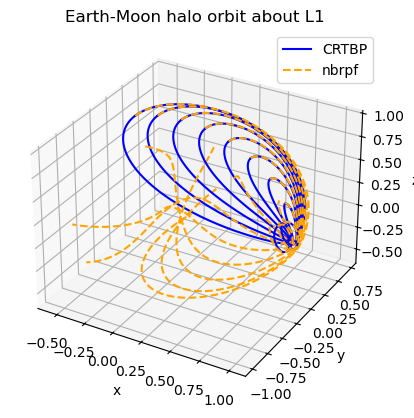

In [59]:
params = {'sys': 'earth-moon', 
            'family': 'halo', 
            'libr': '2',
            'branch' : 'N',
            'periodmin' : None,
            'periodmax' : None,
            'periodunits' : None,
            'jacobimin' : None,
            'jacobimax' : None,
            'stabmin' : None,
            'stabmax' : None
            }
# sys : sun-earth, sun-mars, earth-moon, mars-phobos, jupiter-europa, 
#       saturn-enceladus, saturn-titan
# family : halo,vertical,axial,lyapunov,longp,short,butterfly,
#          dragonfly,resonant,dro,dpo,lpo
# libr : 1,2,3,4,5
# branch : branch of orbits within the family: N/S for halo,dragonfly,butterfly,
#          E/W for lpo, and pq integer sequence for resonant (e.g., 12 for 1:2).
# periodmin - periodmax : float defined by periodunits
# periodunits : s, h, d, TU
# jacobimin - jacobimax : float ND
# stabmin - stabmax : positive

#data = api_get(params)

numResults = len(data['data'])
print('Found ' + str(numResults) + ' orbits')

orbits_to_display = 10 # How many orbits in the family to display
TU = float(data['system']['tunit']) # Time factor in seconds
LU = float(data['system']['lunit']) # Length factor in km

# CRTBP Params
mu = float(data['system']['mass_ratio']) # mass ratio
t0 = 0.0
# tf is period
ode_rtol = 1e-12
ode_atol = 1e-12
N = 100
u_guess = np.zeros((6, 3))
p_guess = np.empty(0)

param_dict = {'mu': mu, 't0': t0, 'ode_atol': ode_atol, 'ode_rtol': ode_rtol, 'et0': et0}
auxdata = {'param': param_dict}

# n-body params
auxdata['param']["id_primary"] = id_primary
auxdata['param']["id_secondary"] = id_secondary
auxdata['param']["mu_bodies"] = mu_bodies
auxdata['param']["naif_id_bodies"] = naif_id_bodies
auxdata['param']["inertial_frame"] = reference_frame
auxdata['param']["abcorr_flag"] = "None"
auxdata['param']["origin_frame"] = "SSB"
auxdata["observer_id"] = observer_id
auxdata["reference_frame"] = reference_frame
auxdata["epoch_t0"] = epoch_t0
auxdata['param']["tau_vec"] = tau_vec
auxdata['param']["t_vec"] = t_vec

plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")


for ind in [int(i * numResults/orbits_to_display) for i in range(orbits_to_display)]:
        # CRTBP Propagation
        tf = float(data['data'][ind][7]) # Non-dim
        x0 = [float(val) for val in data['data'][ind][0:6]]
        dynamics_function = dyn_coeff.dynamics
        auxdata['param']['tf'] = tf
        auxdata['param']['x0'] = x0
        time = np.linspace(t0, param_dict['tf'], N)
        state_array = propagation.propagate(crtbp.dynamics, param_dict['x0'], u_guess, p_guess, time, auxdata)
        if ind == 0:
            ax.plot(state_array[:,0], state_array[:,1], state_array[:,2], color = 'blue', label = 'CRTBP')
        else:
            ax.plot(state_array[:,0], state_array[:,1], state_array[:,2], color = 'blue')

        # n-body Propagation
        auxdata["model"] = 3
        state_array_nb = propagation.propagate(dyn_rnbp_nonuniform.dynamics, param_dict['x0'], u_guess, p_guess, time, auxdata)
        if ind == 0:
            ax.plot(state_array_nb[:,0], state_array_nb[:,1], state_array_nb[:,2], color = 'orange', linestyle = '--', label = 'nbrpf')
        else:
            ax.plot(state_array_nb[:,0], state_array_nb[:,1], state_array_nb[:,2], color = 'orange', linestyle = '--')

system = data['system']['name']
if data['family'] in ['lyapunov', 'halo', 'longp', 'short', 'axial', 'vertical']:
    ax.set_title(system + ' ' + data['family'] + ' orbit about L' + data['libration_point'])
else:
    ax.set_title(system + ' ' + data['family'] + ' orbit')
plt.legend()

In [6]:
auxdata = {}
model = 1
auxdata = {"model": model, "mu_crtbp": mu_crtbp, "mu_sun": mu_sun, "a_sun": a_sun, "om_sun": om_sun, "sun_angle_t0": sun_angle_t0}

tau = 1.2345
state_syn = np.array([0.8741, 0.563, -0.265, 1.189, -0.486, 0.567])
control = 0.0
p_param = 0.0
auxdata["model"] = 1
dyn_crtbp_ref = dyn.dynamics_crtbp_ref(state_syn, mu_crtbp)
dyn_crtbp_coeff = dyn.dynamics(tau, state_syn, control, p_param, auxdata)
diff_dyn_crtbp = dyn_crtbp_ref - dyn_crtbp_coeff
# print("diff_dyn_crtbp: ", diff_dyn_crtbp)
print("max diff_dyn_crtbp: ", np.max(np.abs(diff_dyn_crtbp)))

jac_crtbp_ref = dyn.jacobian_crtbp_ref(state_syn, mu_crtbp)
jac_crtbp_coeff = dyn.jacobian(tau, state_syn, control, p_param, auxdata)
diff_jac_crtbp = jac_crtbp_ref - jac_crtbp_coeff
# print("diff_jac_crtbp: ", diff_jac_crtbp)
print("max diff_jac_crtbp: ", np.max(np.abs(diff_jac_crtbp)))


auxdata["model"] = 2

dyn_bcrfbp_ref = dyn.dynamics_bcrfbp_ref(tau, state_syn, mu_crtbp, mu_sun, a_sun, om_sun, sun_angle_t0)
dyn_bcrfbp_coeff = dyn.dynamics(tau, state_syn, control, p_param, auxdata)
diff_dyn_bcrfbp = dyn_bcrfbp_ref - dyn_bcrfbp_coeff
# print("diff_dyn_bcrfbp: ", diff_dyn_bcrfbp)
print("max diff_dyn_bcrfbp: ", np.max(np.abs(diff_dyn_bcrfbp)))

jac_bcrfbp_ref = dyn.jacobian_bcrfbp_ref(tau, state_syn, mu_crtbp, mu_sun, a_sun, om_sun, sun_angle_t0)
jac_bcrfbp_coeff = dyn.jacobian(tau, state_syn, control, p_param, auxdata)
diff_jac_bcrfbp = jac_bcrfbp_ref - jac_bcrfbp_coeff
# print("diff_jac_bcrfbp: ", diff_jac_bcrfbp)
print("max diff_jac_bcrfbp: ", np.max(np.abs(diff_jac_bcrfbp)))




epoch_t0 = spice.str2et('23 September 2022 00:00:00 TDB')
reference_frame = "j2000"
mu_p = mu_bodies[id_primary]
mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]
naif_id_s = naif_id_bodies[id_secondary]

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0
tau_f = 100.0
t0 = 0.0
n_points = 5000
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)

auxdata["id_primary"] = id_primary
auxdata["id_secondary"] = id_secondary
auxdata["mu_bodies"] = mu_bodies
auxdata["naif_id_bodies"] = naif_id_bodies
auxdata["observer_id"] = 0
auxdata["reference_frame"] = reference_frame
auxdata["epoch_t0"] = epoch_t0
auxdata["tau_vec"] = tau_vec_input
auxdata["t_vec"] = t_vec

param = {}
param["id_primary"] = id_primary
param["id_secondary"] = id_secondary
param["mu_bodies"] = mu_bodies
param["naif_id_bodies"] = naif_id_bodies
param["origin_frame"] = "SSB"
param["abcorr_flag"] = "None"
param["inertial_frame"] = reference_frame
param["et0"] = epoch_t0
param["tau_vec"] = tau_vec_input
param["t_vec"] = t_vec

input_dict = {}
input_dict = {"param": param}

auxdata["model"] = 3
dyn_rnbp_rpf_ref = dyn_rnbp_nonuniform.dynamics_coeff_table(tau, state_syn, control, p_param, input_dict)
dyn_rnbp_rpf_coeff = dyn.dynamics(tau, state_syn, control, p_param, auxdata)
diff_dyn_rnbp_rpf = dyn_rnbp_rpf_ref - dyn_rnbp_rpf_coeff
# print("diff_dyn_rnbp_rpf: ", diff_dyn_rnbp_rpf)
print("max diff_dyn_rnbp_rpf: ", np.max(np.abs(diff_dyn_rnbp_rpf)))

jac_rnbp_rpf_ref = dyn_rnbp_nonuniform.jacobian_x_standalone(tau, state_syn, control, p_param, input_dict)
jac_rnbp_rpf_coeff = dyn.jacobian(tau, state_syn, control, p_param, auxdata)
diff_jac_rnbp_rpf = jac_rnbp_rpf_ref - jac_rnbp_rpf_coeff
# print("diff_jac_rnbp_rpf: ", diff_jac_rnbp_rpf)
print("max diff_jac_rnbp_rpf: ", np.max(np.abs(diff_jac_rnbp_rpf)))



u_bar:  [-0.19010944 -0.09799183 -0.21887596]
max diff_dyn_crtbp:  2.7755575615628914e-17
max diff_jac_crtbp:  1.6653345369377348e-16
max diff_dyn_bcrfbp:  2.220446049250313e-16
max diff_jac_bcrfbp:  6.661338147750939e-16
max diff_dyn_rnbp_rpf:  0.0
max diff_jac_rnbp_rpf:  1.3322676295501878e-15
